In [1]:
import numpy as np
import os
import array
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [ ]:
num_workers = 0
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

dataset_path = r"(my_file_path)"

meta = unpickle(os.path.join(dataset_path, "batches.meta"))
label_names = meta[b'label_names']  # List of class names
label_names = [name.decode("utf-8") for name in label_names]
print(label_names)
# Load all training batches
train_data = []
train_labels = []

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
for i in range(1, 6):
    batch = unpickle(os.path.join(dataset_path, f"data_batch_{i}"))
    train_data.append(batch[b"data"])
    train_labels.extend(batch[b"labels"])  # List of labels


[6 9 9 ... 9 1 1]


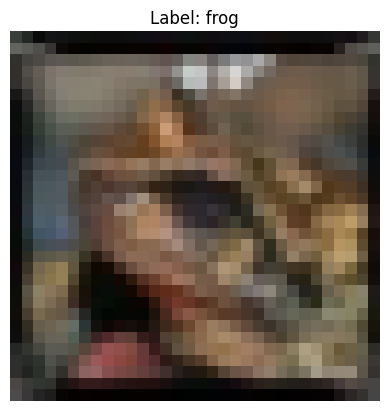

In [5]:
# Convert to numpy arrays
train_data = np.vstack(train_data)  # Shape: (50000, 3072)
train_labels = np.array(train_labels)  # Shape: (50000,)
print(train_labels)

# Load test batch
test_batch = unpickle(os.path.join(dataset_path, "test_batch"))
test_data = test_batch[b"data"]
test_labels = np.array(test_batch[b"labels"])

# Function to display an image
def show_image(image_data, train_labels):
    image = image_data.reshape(3, 32, 32).transpose(1, 2, 0)  # Reshape and reorder channels
    plt.imshow(image)
    plt.title(f"Label: {train_labels}")
    plt.axis("off")
    plt.show()
# Maybe add a feature to scroll through all pictures, how does that work on kaggle
# Show a random training image
index = np.random.randint(0, train_data.shape[0])
show_image(train_data[index], label_names[train_labels[index]])

In [6]:
# Convert NumPy arrays to PyTorch tensors
train_data_tensor = torch.tensor(train_data, dtype=torch.float32) / 255.0  # Normalize to [0,1]
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

# Normalize to [-1, 1]
train_data_tensor = 2 * train_data_tensor - 1

test_data_tensor = torch.tensor(test_data, dtype=torch.float32) / 255.0
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Normalize to [-1, 1]
test_data_tensor = 2 * test_data_tensor - 1

# Reshape data to (N, 3, 32, 32) for PyTorch (NCHW format)
train_data_tensor = train_data_tensor.view(-1, 3, 32, 32)
test_data_tensor = test_data_tensor.view(-1, 3, 32, 32)

print(f"-\n-{train_data_tensor.shape},\n\n\n{train_labels_tensor}--{train_labels_tensor.shape}")

-
-torch.Size([50000, 3, 32, 32]),


tensor([6, 9, 9,  ..., 9, 1, 1])--torch.Size([50000])


In [7]:
def symmetric_noise(labels, noise_level):
    global num_classes
    num_classes = 10
    
    """Introduce symmetric label noise at a given noise level."""
    assert 0 <= noise_level <= 1, "Noise level must be between 0 and 1"
    labels = labels.clone()  # Copy to avoid modifying the original tensor
    num_samples = len(labels)
    num_noisy = int(noise_level * num_samples)  # Number of labels to corrupt
    seed = np.random.randint(1e9)  # Random seed
    torch.manual_seed(seed)
    noisy_indices = torch.randperm(num_samples)[:num_noisy]  # Randomly select indices to corrupt
    noisy_labels = labels.clone()

    for idx in noisy_indices:
        original_label = noisy_labels[idx].item()
        possible_classes = list(set(range(num_classes)) - {original_label})  # Exclude original label
        noisy_labels[idx] = torch.tensor(np.random.choice(possible_classes))  # Randomly choose a new label

    return noisy_labels
label = []
noisy_labels = []
noise_level = array.array('f', [0.4, 0.5, 0.6, 0.7, 0.8])
labels = train_labels_tensor[:50000]

In [8]:
# Apply noise from 40% to 80% 
noise_level_4 = symmetric_noise(labels, 0.4)
print(f"Applied {noise_level[0] * 100:.0f}% symmetric noise. Example noisy labels:", noise_level_4)
noise_level_5 = symmetric_noise(labels, 0.5)
print(f"Applied {noise_level[1] * 100:.0f}% symmetric noise. Example noisy labels:", noise_level_5)
noise_level_6 = symmetric_noise(labels, 0.6)
print(f"Applied {noise_level[2] * 100:.0f}% symmetric noise. Example noisy labels:", noise_level_6)
noise_level_7 = symmetric_noise(labels, 0.7)
print(f"Applied {noise_level[3] * 100:.0f}% symmetric noise. Example noisy labels:", noise_level_7)
noise_level_8 = symmetric_noise(labels, 0.8)    
print(f"Applied {noise_level[4] * 100:.0f}% symmetric noise. Example noisy labels:", noise_level_8)

Applied 40% symmetric noise. Example noisy labels: tensor([9, 9, 9,  ..., 1, 9, 1])
Applied 50% symmetric noise. Example noisy labels: tensor([6, 3, 9,  ..., 3, 1, 4])
Applied 60% symmetric noise. Example noisy labels: tensor([9, 4, 0,  ..., 3, 1, 8])
Applied 70% symmetric noise. Example noisy labels: tensor([6, 1, 9,  ..., 6, 0, 1])
Applied 80% symmetric noise. Example noisy labels: tensor([1, 3, 5,  ..., 9, 0, 2])


In [9]:
asymmetric_class_map = {
    2: 0,  # "bird" → "airplane"
    4: 9,  # "deer" → "horse"
    7: 2,  # "horse" → "dog"
    1: 7,  # "automobile" → "truck"
    3: 5   # "cat" → "dog"
}
def asymmetric_noise(labels, noise_level,asymmetric_class_map):
    """Introduce asymmetric label noise at a given noise level."""
    assert 0 <= noise_level <= 1, "Noise level must be between 0 and 1"

    labels = labels.clone()  # Copy to avoid modifying the original tensor
    num_samples = len(labels)
    num_noisy = int(noise_level * num_samples)  # Number of labels to corrupt

    seed = np.random.randint(1e9)  # Random seed
    torch.manual_seed(seed)
    noisy_indices = torch.randperm(num_samples)[:num_noisy]  # Randomly select indices to corrupt
    noisy_labels = labels.clone()

    for idx in noisy_indices:
        original_label = noisy_labels[idx].item()
        if original_label in asymmetric_class_map:
            noisy_labels[idx] = asymmetric_class_map[original_label]  # Apply predefined mapping

    return noisy_labels

# Explanation of Noise Types in CIFAR-10 Dataset Variants 

**two types of label noises used**:  
1. **Symmetric Noise** (Noise Levels 4–8)  
2. **Asymmetric Noise** (Asymmetry Levels 1–3)  

Each type of noise serves a different purpose in understanding model robustness. Below is a detailed explanation of these noise types, their significance, and their real-world relevance.

---

## **1. Symmetric Label Noise (Noise Levels 4–8)**  

### **Definition:**  
Symmetric noise refers to **random label corruption** where each class label has a fixed probability of being replaced with any other class **uniformly**. This means that for a given noise level \( p \), each true label has a \( p \) probability of being randomly reassigned to one of the remaining \( K-1 \) classes (where \( K \) is the total number of classes).  

### **Mathematical Formulation:**  
Given a dataset with **true labels** \( y \) and a noise rate \( p \), the noisy label \[$( \tilde{y}\ )$] is assigned as:

\[
$P(\tilde{y} = j | y = i) = 
\begin{cases}
1 - p, & \text{if } j = i \\
\frac{p}{K-1}, & \text{if } j \neq i
\end{cases}$

\]

where:
- \( i \) is the correct class label.
- \( j \) is any class label (including incorrect ones).
- \( p \) is the probability of label corruption.

### **Significance in Machine Learning:**  
1. **Simulates human annotation errors**: In large-scale datasets, labelers can mislabel samples due to fatigue or ambiguity.  
2. **Evaluates robustness of loss functions**: Loss functions like **Normalized Cross-Entropy (NCE), Mean Absolute Error (MAE), and Reverse Cross-Entropy (RCE)** are tested against increasing noise levels.  
3. **Tests regularization techniques**: Noise forces the model to rely on meaningful patterns instead of memorizing incorrect labels.  

### **Real-World Applications:**  
- **Medical Imaging**: Doctors may mislabel X-ray or MRI scans due to fatigue or image ambiguity.  
- **Autonomous Vehicles**: Incorrectly labeled pedestrian vs. cyclist images in training datasets.  
- **Crowdsourced Annotations**: Platforms like Amazon Mechanical Turk introduce noisy labels due to human errors.  

---

## **2. Asymmetric Label Noise (Asymmetry Levels 1–3)**  

### **Definition:**  
Asymmetric noise introduces **structured mislabeling**, where specific classes are more likely to be confused with similar-looking classes. This mimics real-world classification mistakes where certain objects share visual similarities.  

### **Mathematical Formulation:**  
For a noise level \( p \), labels are flipped **only within semantically similar classes**. The probability of label corruption follows:

\[
$P(\tilde{y} = j | y = i) =
\begin{cases}
1 - p, & \text{if } j = i \\
p, & \text{if } j \text{ is a visually similar class to } i
\end{cases}$
\]

where:
- **Examples of structured label corruption in CIFAR-10**:
  - **Truck → Automobile**
  - **Cat → Dog**
  - **Deer → Horse**
  - **Bird → Airplane**

In [ ]:
# Define asymmetric noise levels 
asym_levels = array.array('f', [0.1 , 0.2 ,0.4])

# Apply asymmetric noise
labels = train_labels_tensor[:50000]  # Original labels
asym_level_1 = asymmetric_noise(labels, asym_levels[0], asymmetric_class_map)
print(f"Applied {asym_levels[0] * 100:.0f}% asymmetric noise. Example noisy labels:", asym_level_1)
asym_level_2 = asymmetric_noise(labels, asym_levels[1], asymmetric_class_map)
print(f"Applied {asym_levels[1] * 100:.0f}% asymmetric noise. Example noisy labels:", asym_level_2)
asym_level_3 = asymmetric_noise(labels, asym_levels[2], asymmetric_class_map)
print(f"Applied {asym_levels[2] * 100:.0f}% asymmetric noise. Example noisy labels:", asym_level_3)

Applied 10% asymmetric noise. Example noisy labels: tensor([6, 9, 9,  ..., 9, 1, 1])
Applied 20% asymmetric noise. Example noisy labels: tensor([6, 9, 9,  ..., 9, 1, 7])
Applied 40% asymmetric noise. Example noisy labels: tensor([6, 9, 9,  ..., 9, 1, 7])


In [11]:
batch_size=128
train_dl = DataLoader(test_data_tensor, batch_size, shuffle=True, num_workers=4, pin_memory=True)


class CIFAR10TensorDataset(Dataset):
    """Custom Dataset for loading CIFAR-10 tensors"""
    def __init__(self, data_tensor, labels_tensor):
        self.data = data_tensor.float()  # Ensure floating point
        self.labels = labels_tensor.long()  # Ensure integer labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [ ]:
train_dataset= CIFAR10TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = CIFAR10TensorDataset(test_data_tensor, test_labels_tensor)
train_dataset_4 = CIFAR10TensorDataset(train_data_tensor, noise_level_4)
train_dataset_5 = CIFAR10TensorDataset(train_data_tensor, noise_level_5)
train_dataset_6 = CIFAR10TensorDataset(train_data_tensor, noise_level_6)
train_dataset_7 = CIFAR10TensorDataset(train_data_tensor, noise_level_7)
train_dataset_8 = CIFAR10TensorDataset(train_data_tensor, noise_level_8)
train_dataset_1 = CIFAR10TensorDataset(train_data_tensor, asym_level_1)
train_dataset_2 = CIFAR10TensorDataset(train_data_tensor, asym_level_2)
train_dataset_3 = CIFAR10TensorDataset(train_data_tensor, asym_level_3)


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
train_loader_4 = DataLoader(train_dataset_4, batch_size=64, shuffle=True)
train_loader_5 = DataLoader(train_dataset_5, batch_size=64, shuffle=True)
train_loader_6 = DataLoader(train_dataset_6, batch_size=64, shuffle=True)
train_loader_7 = DataLoader(train_dataset_7, batch_size=64, shuffle=True)
train_loader_8 = DataLoader(train_dataset_8, batch_size=64, shuffle=True)
train_loader_1 = DataLoader(train_dataset_1, batch_size=64, shuffle=True)
train_loader_2 = DataLoader(train_dataset_2, batch_size=64, shuffle=True)
train_loader_3 = DataLoader(train_dataset_3, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

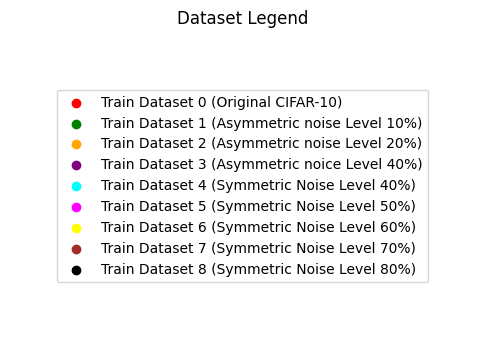

In [99]:
dataset_labels = [
    "Train Dataset 0 (Original CIFAR-10)",
    "Train Dataset 1 (Asymmetric noise Level 10%)",
    "Train Dataset 2 (Asymmetric noise Level 20%)",
    "Train Dataset 3 (Asymmetric noice Level 40%)",
    "Train Dataset 4 (Symmetric Noise Level 40%)",
    "Train Dataset 5 (Symmetric Noise Level 50%)",
    "Train Dataset 6 (Symmetric Noise Level 60%)",
    "Train Dataset 7 (Symmetric Noise Level 70%)",
    "Train Dataset 8 (Symmetric Noise Level 80%)",

]

colors = [
    "red", "green", "orange", "purple", "cyan", "magenta", "yellow", "brown", "black"
]

# Create an empty figure for the legend
fig, ax = plt.subplots(figsize=(6, 4))
for i in range(len(dataset_labels)):
    ax.scatter([], [], color=colors[i], label=dataset_labels[i])  # Invisible points for legend

# Display legend
ax.legend(loc="center", frameon=True, fontsize=10)
ax.axis("off")  # Hide axes
plt.title("Dataset Legend", fontsize=12)
plt.show()


In [13]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # Average pooling layer
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(0.5)



    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)  # Flatten
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [86]:
class NormalizedCrossEntropy(nn.Module):
    def __init__(self, num_classes=10, alpha=0.1):

        super(NormalizedCrossEntropy, self).__init__()
        self.num_classes = num_classes
        self.alpha = alpha  # Controls the normalization factor

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
        target_probs = probs[torch.arange(logits.shape[0]), targets].clamp(min=1e-8, max=1.0)  # Get the probability of the true class


        # Compute the loss: -log(p_i) normalized by (1 - p_i)^alpha
        loss = -torch.log(target_probs + 1e-8) / ((1 - target_probs).clamp(min=1e-8) ** self.alpha + 1e-8)
        
        return loss.mean()  # Return mean loss



class NormalizedFocalLoss(nn.Module):
    def __init__(self, gamma=2, num_classes=10):
        super(NormalizedFocalLoss, self).__init__()
        self.gamma = gamma
        self.num_classes = num_classes

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)
        one_hot_targets = F.one_hot(targets, self.num_classes).float()
        
        pt = (one_hot_targets * probs).sum(dim=1)  # Get probability of true class
        focal_weight = (1 - pt) ** self.gamma  # Compute focal weight
        loss = -focal_weight * torch.sum(one_hot_targets * torch.log(probs + 1e-9), dim=1)
        
        # Normalize
        norm_factor = torch.sum(-torch.log(probs + 1e-9), dim=1)
        loss /= norm_factor
        return loss.mean()

class ReverseCrossEntropy(nn.Module):
    def __init__(self, num_classes=10):
        super(ReverseCrossEntropy, self).__init__()
        self.num_classes = num_classes

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)
        one_hot_targets = F.one_hot(targets, self.num_classes).float()
        loss = -torch.sum((1 - one_hot_targets) * torch.log(1 - probs + 1e-9), dim=1)
        return loss.mean()

class MAELoss(nn.Module):
    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)
        one_hot_targets = F.one_hot(targets, logits.shape[1]).float()
        loss = torch.abs(one_hot_targets - probs).sum(dim=1)
        return loss.mean()


# 1. Normalized Cross-Entropy Loss

For a given sample, let $p$ be the predicted probability for the true class and $\alpha$ be a hyperparameter:

$$
L = \frac{-\ln(p)}{(1 - p)^\alpha}
$$

For a batch of $N$ samples, the final loss is the average:

$$
L_{\text{final}} = \frac{1}{N} \sum_{i=1}^{N} \frac{-\ln(p_i)}{(1 - p_i)^\alpha}
$$

---

# 2. Normalized Focal Loss

The probability of the true class:

$$
p_t = \sum_{j=1}^{C} y_j p_j
$$

where $y_j$ is 1 if class $j$ is the true class, and 0 otherwise.

The focal weight:

$$
\text{Focal Weight} = (1 - p_t)^\gamma
$$

The loss function:

$$
L = -\text{Focal Weight} \sum_{j=1}^{C} y_j \ln(p_j)
$$

With normalization:

$$
L = \frac{-\text{Focal Weight} \sum_{j=1}^{C} y_j \ln(p_j)}{\sum_{j=1}^{C} -\ln(p_j)}
$$

---

# 3. Reverse Cross-Entropy Loss

$$
L = -\sum_{j=1}^{C} (1 - y_j) \ln(1 - p_j)
$$

where $(1 - y_j)$ ignores the true class and instead focuses on incorrect predictions.

---

# 4. Mean Absolute Error (MAE) Loss

$$
L = \sum_{j=1}^{C} |y_j - p_j|
$$

where $y_j$ is the one-hot encoded label and $p_j$ is the predicted probability for class $j$.


In [ ]:
import json

def train_model(model, train_loader, test_loader, loss_function, device="cuda", epochs=10 , model_name="training_model-1"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    logs = {
        "train_loss": [],
        "test_acc": []
    }

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = torch.argmax(outputs, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_acc = correct / total

        logs["train_loss"].append(train_loss)
        logs["test_acc"].append(test_acc)

        print(f"Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    torch.save(model.state_dict(), f"{model_name}.pth")
    with open(f"{model_name}_logs.json", "w") as f:
        json.dump(logs, f, indent=4)

    return logs
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total

In [ ]:
def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SimpleCNN(num_classes=10)

    # Train with Normalized Cross-Entropy
    print("\nTraining with NCE Loss: ")
    nce_loss = NormalizedCrossEntropy(num_classes=10, alpha=0.1)
    train_model(model, train_loader, test_loader, loss_function=nce_loss, device=device)

    # Train with Normalized Focal Loss
    print("\nTraining with NFL Loss: ")
    nfl_loss = NormalizedFocalLoss(gamma=2, num_classes=10)
    train_model(model, train_loader, test_loader, loss_function=nfl_loss, device=device)

    # Train with Reverse Cross-Entropy
    print("\nTraining with RCE Loss: ")
    rce_loss = ReverseCrossEntropy(num_classes=10)
    train_model(model, train_loader, test_loader, loss_function=rce_loss, device=device)

    # Train with Mean Absolute Error Loss
    print(f"\nTraining with MAE Loss: ")
    mae_loss = MAELoss()
    train_model(model, train_loader, test_loader, loss_function=mae_loss, device=device)

if __name__ == "__main__":
    main()

# Loss Function Performance Analysis for original CIFAR-10 dataset

These results compare the performance of different loss functions—**Normalized Cross-Entropy (NCE), Normalized Focal Loss (NFL), Reverse Cross-Entropy (RCE), and Mean Absolute Error (MAE)**—on a classification task over 10 training epochs.

## **Key Observations**
### **1. NCE Loss**
- Shows steady improvement in accuracy.
- Reaches **81.43% train accuracy** and **78.81% test accuracy** by epoch 10.

### **2. NFL Loss**
- Starts with a much lower train loss than NCE, indicating faster convergence.
- However, test accuracy plateaus early at **75.97%**, despite a high **82.48% train accuracy**.
- This suggests potential **overfitting**.

### **3. RCE Loss**
- Achieves the **highest train accuracy (90.47%)** and a competitive **80.03% test accuracy**.
- Might also suggest **overfitting** however, converged the fastest amongst all loss functions and will be interesting to see how it behaves on noisy labels

### **4. MAE Loss**
- Struggles with convergence, showing **fluctuations in both train and test accuracy**.
- Reaches **87.84% train accuracy** and **77.70% test accuracy**.
- MAE is highly sensitive to label noise, making it **less stable** but works very well for clean data as seen above.

## **Summary**
- **RCE and NCE perform the best overall**, with **RCE achieving the highest accuracy and the fastest convergence**.
- **NCE remains more stable**, making it a strong choice for noisy-label learning.
- **NFL converges quickly but shows signs of overfitting**.

Overall, **RCE and NCE are the most robust loss functions in the above experiment, but any loss function will suffice without much loss in accuracy**.


In [ ]:
def run_all_losses():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SimpleCNN(num_classes=10)

    # Loss functions
    losses = {
        "NCE" :NormalizedCrossEntropy(num_classes=10,alpha=0.1),
        "NFL": NormalizedFocalLoss(gamma=2, num_classes=10),
        "RCE": ReverseCrossEntropy(num_classes=10),
        "MAE": MAELoss()
    }

    # Dictionary to store results
    results = {name: {} for name in losses.keys()}

    # Train on different datasets
    for i, train_loader in enumerate([train_loader_1, train_loader_2, train_loader_3, train_loader_4, train_loader_5, train_loader_6, train_loader_7, train_loader_8], start=1):
        print(f"\nTraining on train_loader_{i}...")
        for loss_name, loss_func in losses.items():
            print(f"Using {loss_name} loss...")
            model = SimpleCNN(num_classes=10)  # Reset model for fair comparison
            history = train_model(model, train_loader, test_loader, loss_function=loss_func, device=device)

            # Store train loss & test accuracy
            results[loss_name][f"train_loader_{i}"] = history

    return results

res1 = run_all_losses()

# Training Performance Review: Impact of Noise Levels on Model Performance

The training logs provide a detailed analysis of the model's performance across different noise levels (datasets) and loss functions

## Key Observations:

### **1. Noise Levels and Dataset Performance**:
   - **Low-Noise Datasets (e.g., train_loader_1, train_loader_2)**:
     - Models trained on these datasets achieve the highest test accuracy, indicating that lower noise levels facilitate better learning and generalization.
     - NCE and RCE losses perform exceptionally well, with test accuracies reaching **78.81%** and **80.18%**, respectively.
   - **High-Noise Datasets (e.g., train_loader_7, train_loader_8)**:
     - Performance degrades significantly very suddenly, with noice level at **70%** and **80%** might be suggesting limits of certain loss functions used here,. these limitations at very specific value can be investigated and experimented with later on.


### **2. Loss Function Performance**:
   - **NCE Loss**:
     - Demonstrates robust performance across all noise levels, with consistent improvements in training and test accuracy.
     - Particularly effective for low-noise datasets, achieving the highest test accuracy of **78.81%**.
   - **RCE Loss**:
     - Shows strong generalization capabilities, especially in low-noise settings, with test accuracy peaking at **80.18%**.
     - Performs better than NFL and MAE losses in high-noise scenarios, though still struggles with significant noise.
   - **NFL Loss**:
     - Starts with low training loss but exhibits unstable test performance, particularly in high-noise datasets.
     - Test accuracy fluctuates, suggesting sensitivity to noise and overfitting tendencies.
   - **MAE Loss**:
     - Performs poorly across all noise levels, with minimal improvement in test accuracy.
     - Struggles to generalize, even in low-noise settings, making it unsuitable for this task.

### **3. General Trends**:
   - **Low Noise**: Models achieve higher accuracy and stability, with NCE and RCE losses being the top performers.
   - **High Noise**: All loss functions struggle, with test accuracy dropping significantly, indicating that noise severely impacts model learning.


## Conclusion:
The level of noise in the dataset significantly impacts model performance. NCE and RCE losses are the most effective for low-to-moderate noise levels, while high noise levels pose a challenge for all loss functions. Addressing noise through preprocessing or robust modeling techniques is critical for improving performance in high-noise scenarios.

In [ ]:
class AdaptivePolyLoss(nn.Module):
    def __init__(self, alpha=0.762, beta=0.341, gamma=2, num_classes=10, smoothing=0.076):
        super(AdaptivePolyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes
        self.smoothing = smoothing
        self.gamma = gamma

        # Using predefined loss functions
        self.normalized_ce = NormalizedCrossEntropy(num_classes=num_classes, alpha=smoothing)
        self.mae_loss = MAELoss()


    def forward(self, logits, targets):
        nce_loss = self.normalized_ce(logits, targets)
        mae_loss = self.mae_loss(logits, targets)
        loss = self.alpha * (nce_loss) + self.beta * (mae_loss)
        return loss

# Adaptive Poly Loss

Adaptive Poly Loss is a hybrid loss function that combines **Cross-Entropy (CE) Loss** and **Mean Absolute Error (MAE) Loss** with adjustable weights.

### Adaptive Poly Loss (Weighted Sum)**
$$
L_{\text{Adaptive Poly}} = \alpha L_{\text{CE}} + \beta L_{\text{MAE}}
$$
where:
- $\alpha$ and $\beta$  are hyperparameters controlling the weight of CE and MAE loss respectively.

In [ ]:
class NoiseRobustAdaptivePolyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=1.0, q=0.7, num_classes=10, smoothing=0.1, epsilon=1e-10):

        super(NoiseRobustAdaptivePolyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.q = q
        self.num_classes = num_classes
        self.smoothing = smoothing
        self.epsilon = epsilon
        self.normalized_ce = NormalizedCrossEntropy(num_classes=num_classes, alpha=smoothing)
        self.mae_loss = MAELoss()
    def forward(self, logits, targets):

        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()
        targets_one_hot = (1 - self.smoothing) * targets_one_hot + self.smoothing / self.num_classes
        probabilities = F.softmax(logits, dim=-1)
        mae_loss = self.mae_loss(logits, targets)
        gce_loss = (1 - torch.pow(torch.sum(targets_one_hot * probabilities, dim=-1), self.q)) / self.q
        poly_term = torch.sum(targets_one_hot * (1 - probabilities) ** 2, dim=-1)
        confidence = torch.max(probabilities, dim=-1)[0]
        dynamic_alpha = self.alpha * (1 - confidence)  
        dynamic_beta = self.beta * confidence  

        loss = dynamic_alpha * gce_loss + dynamic_beta * mae_loss + self.gamma * poly_term
        return torch.mean(loss)

# **Noise-Robust Adaptive Poly Loss (NRAPL)**  

## **Overview**  
The **NoiseRobustAdaptivePolyLoss (NRAPL)** combines elements from **Generalized Cross-Entropy (GCE), Mean Absolute Error (MAE), and Poly Loss**, dynamically adjusting loss contributions based on prediction confidence.  

### **Key Features**  
- **Dynamic Weighting:** Adjusts **α (GCE weight) and β (MAE weight)** based on confidence.  
- **Robust to Label Noise:** Incorporates **smoothing** and a **poly term** to mitigate overfitting.  
- **Generalization:** Designed to balance between **Adaptive Poly Loss (APL) and Symmetric Cross-Entropy Loss (SCEL)** in both low and high noise levels.  

### **Findings**  
- **Expected to perform between APL and SCEL** across noise levels as expected from my general understanding of such loss functions and empirical data from online sources.  
- **Observed plateau at 10% test accuracy** in high-noise scenarios, making it ineffective for this experiment.  
- **Future Work:** Further adjustments and tuning are required to improve noise robustness and optimization stability.  
---

# **Noise-Robust Adaptive Poly Loss**

## **1. Generalized Cross-Entropy (GCE) Loss**

$$
L_{\text{GCE}} = \frac{1 - \sum_{j=1}^{C} \hat{y}_j p_j^q}{q}
$$

where:
- $p_j$ is the predicted probability for class  j ,
- $\hat{y}_j\ $ is the smoothed one-hot encoded label,
- q  is a noise-robust hyperparameter,
- C  is the number of classes.

## **2. Mean Absolute Error (MAE) Loss**

$$
L_{\text{MAE}} = \frac{1}{C} \sum_{j=1}^{C} | p_j - \hat{y}_j |
$$

## **3. Polynomial Regularization Term**
penalizes low-confidence predictions:

$$
L_{\text{poly}} = \sum_{j=1}^{C} \hat{y}_j (1 - p_j)^2
$$

## **4. Confidence-Based Dynamic Weighting**
The weighting factors for each loss component depend on the model’s confidence:

$$
\alpha_{\text{dynamic}} = \alpha (1 - \max_j p_j)
$$

$$
\beta_{\text{dynamic}} = \beta \max_j p_j
$$

where:
- $ \max_j p_j $ represents the confidence (maximum probability across classes),
- $ \alpha\ $ and  $ \beta\ $ are the initial hyperparameters.

## **5. Final Loss Function**
The total Noise-Robust Adaptive Poly Loss is given by:

$$
L_{\text{NR-APL}} = \alpha_{\text{dynamic}} L_{\text{GCE}} + \beta_{\text{dynamic}} L_{\text{MAE}} + \gamma L_{\text{poly}}
$$

where:
- $ \gamma\ $ is the weighting factor for the polynomial term.

In [ ]:
class SymmetricCrossEntropyLoss(nn.Module):
    def __init__(self, alpha=0.1, beta=1.0):
        super(SymmetricCrossEntropyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, y_pred, y_true):
        y_pred = F.softmax(y_pred, dim=1)  # Ensure logits are converted to probabilities
        y_pred = torch.clamp(y_pred, min=1e-7, max=1.0)
        y_true = F.one_hot(y_true, num_classes=10).float()  # Convert labels to one-hot
        y_true = torch.clamp(y_true, min=1e-4, max=1.0)

        ce_loss = -torch.sum(y_true * torch.log(y_pred), dim=-1).mean()
        rce_loss = -torch.sum(y_pred * torch.log(y_true), dim=-1).mean()

        return self.alpha * ce_loss + self.beta * rce_loss


# Symmetric Cross Entropy Loss:-

## 1. Combines Normal cross entropy loss and Reversed Cross Entropy loss.


---

### ** SCE Loss**
The final **Symmetric Cross-Entropy (SCE) Loss** is a weighted combination of CE and RCE:

$$
L_{\text{SCE}} = \alpha L_{\text{CE}} + \beta L_{\text{RCE}}
$$

where:
- $ \alpha\ $ and $ \beta\ $ are weighting hyperparameters.


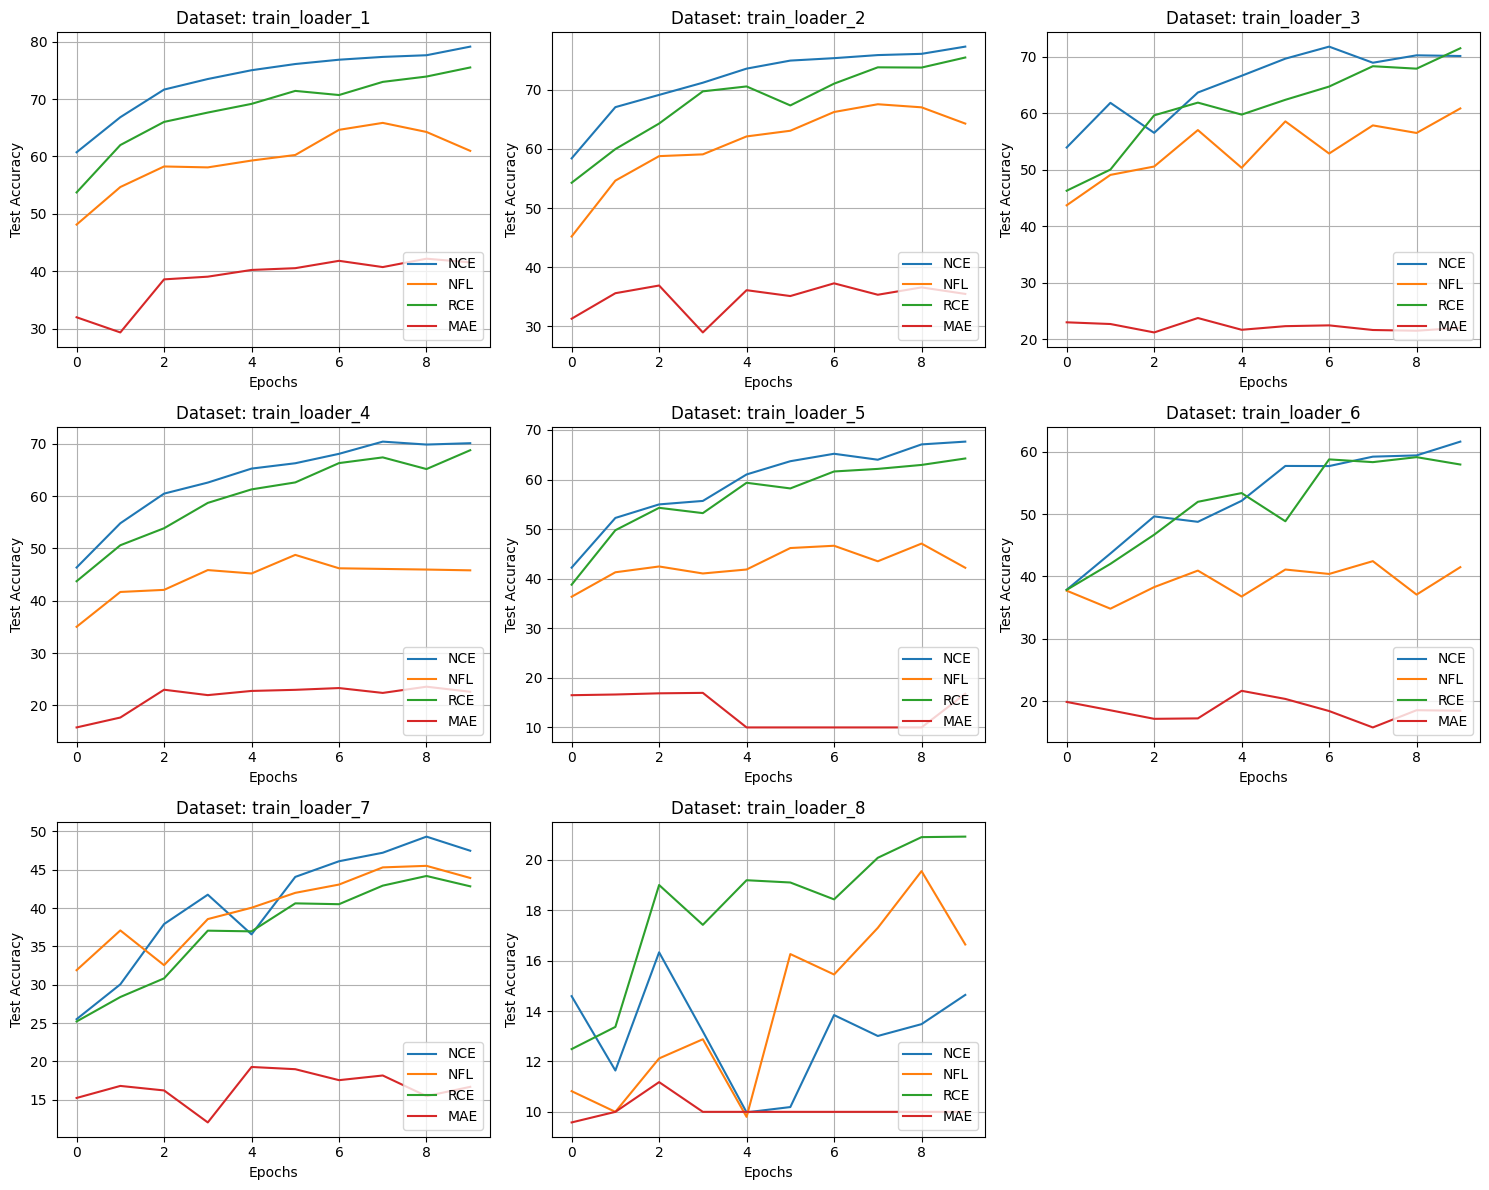

In [89]:
def plot_results(results):
    num_datasets = len(next(iter(results.values())))  # Get number of datasets (9)
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # 3x3 grid of subplots
    axes = axes.flatten()  # Flatten the 2D array for easier iteration

    for i, dataset_name in enumerate(next(iter(results.values())).keys()):
        ax = axes[i]  # Select the subplot for this dataset

        for loss_name, datasets in results.items():
            if dataset_name in datasets:  # Ensure dataset exists in results
                history = datasets[dataset_name]
                label = f"{loss_name}"
                accuracy_percent = [acc * 100 for acc in history["test_acc"]]
                # Plot accuracy
                ax.plot(accuracy_percent, label=label)

        ax.set_xlabel("Epochs")
        ax.set_ylabel("Test Accuracy")
        ax.set_title(f"Dataset: {dataset_name}")
        ax.legend(loc="lower right")
        ax.grid(True)
    for j in range(num_datasets, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()



plot_results(res1)


In [74]:
def train_model2(model, train_loader, test_loader, loss_function, device="cuda", model_name="training_model-2"):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.to(device)

    history = {"train_loss": [], "train_acc": [], "test_acc": []}   

    for epoch in range(15):  
        model.train()
        total_loss = 0.0
        correct_train, total_train = 0, 0  

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        train_accuracy = correct_train / total_train  

        history["train_loss"].append(avg_loss)   
        history["train_acc"].append(train_accuracy)  

        model.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        history["test_acc"].append(test_accuracy)  

        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Train Acc = {train_accuracy:.4f}, Test Acc = {test_accuracy:.4f}")

    torch.save(model, f"{model_name}_full.pth")
    with open(f"{model_name}_logs.json", "w") as f:
        json.dump(history, f, indent=4)

    return history

In [ ]:
def run_loss():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Initialize models and loss functions
    losses = {
        "APL": AdaptivePolyLoss(alpha=0.7, beta=0.3, num_classes=10, smoothing=0.1),
        "SCEL" : SymmetricCrossEntropyLoss(alpha=0.1, beta=1.0)
    }

    # Store results separately for each loss function
    results = {"APL": {}, "SCEL": {}}

    train_loaders = [train_loader_1, train_loader_2, train_loader_3, train_loader_4, 
                     train_loader_5, train_loader_6, train_loader_7, train_loader_8]
    
    # Train on different datasets using both loss functions
    for i, train_loader in enumerate(train_loaders, start=1):
        print(f"\nTraining on Dataset {i}...")

        for loss_name, loss_fn in losses.items():
            print(f"  Using {loss_name}...")

            model = SimpleCNN(num_classes=10).to(device)  # Reset model for each loss function
            history = train_model2(model, train_loader, test_loader, loss_function=loss_fn, device=device)

            # Save results in respective dictionary
            results[loss_name][f"train_loader_{i}"] = history

    return results

# Run training for both loss functions
res2 = run_loss()

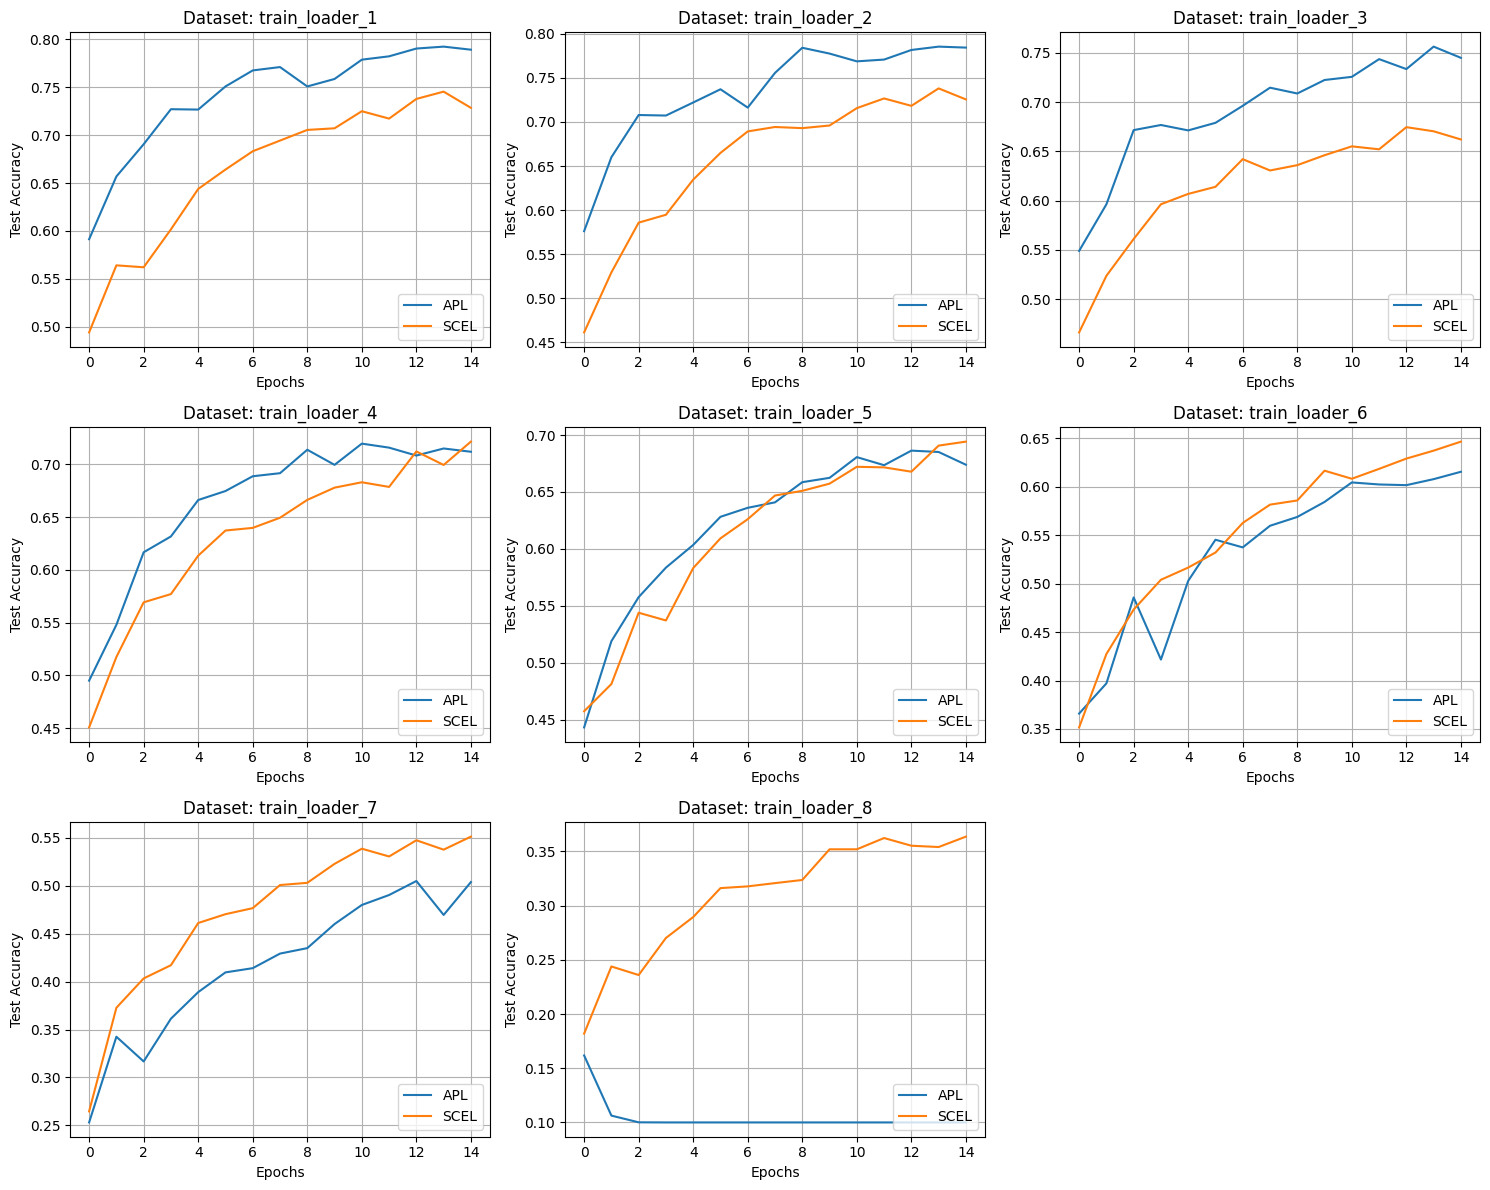

In [80]:
plot_results(res2)

# **Analysis of APL vs. SCEL Across Noise Levels**

This visualization compares **Adaptive Poly Loss (APL)** and **Symmetric Cross-Entropy Loss (SCEL)** on different noisy datasets.  

## **Key Observations**
- **Low-Noise Datasets (train_loader_1 to train_loader_5):**  
  - APL consistently outperforms SCEL, achieving higher test accuracy.  
  - Both losses converge well, but APL shows a more stable improvement.  

- **Moderate-High Noise (train_loader_6, train_loader_7):**  
  - Performance gap narrows; SCEL performs competitively.  
  - APL maintains a slight edge in stability.  

- **Extreme Noise (train_loader_8):**  
  - SCEL surpasses APL, indicating better robustness in high-noise settings.  

## **Suggestions for Improvement**
- **Hybrid Loss Strategies:** Combining APL and SCEL adaptively based on noise levels could improve robustness.  
- **Regularization Techniques:** Implementing noise correction or self-training methods could enhance performance in high-noise scenarios.  
- **Longer Training for High-Noise Datasets:** Extending training beyond 15 epochs may help models converge better in noisy conditions.  


C:\Users\saatw\AppData\Local\Temp\ipykernel_584\665577735.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


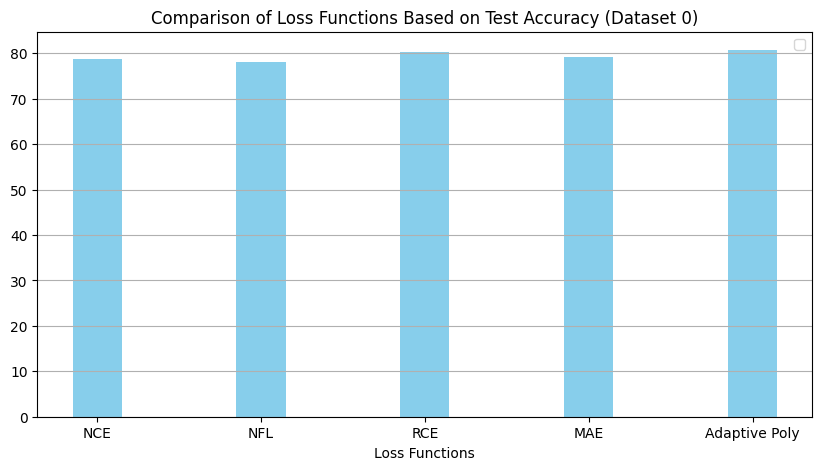

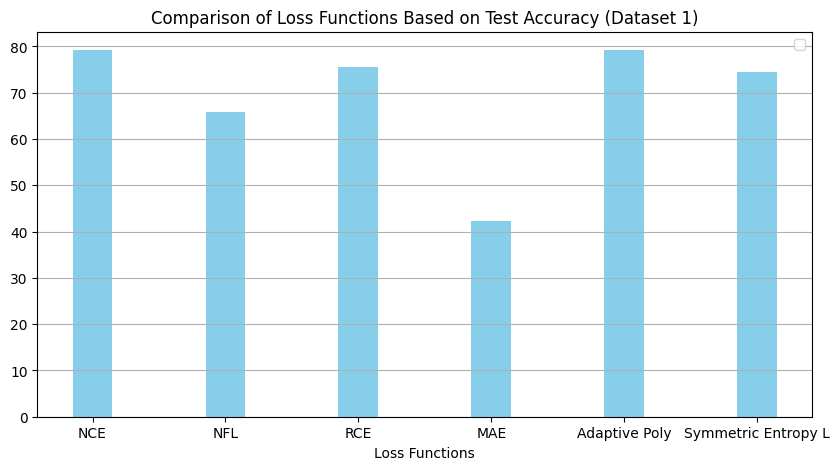

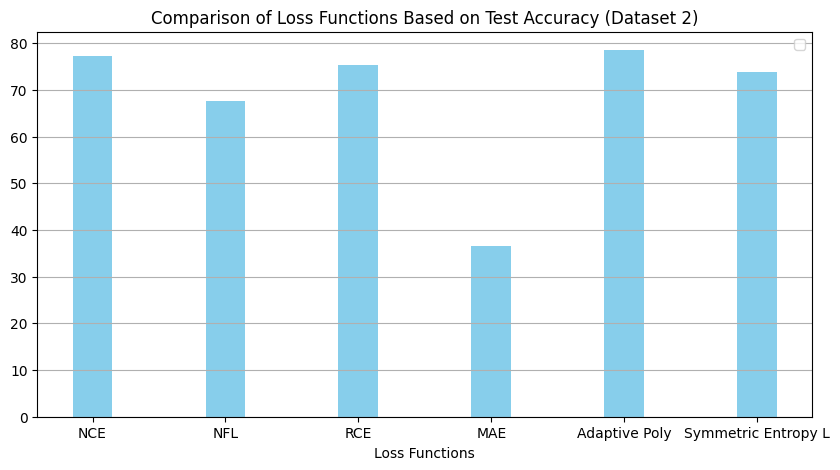

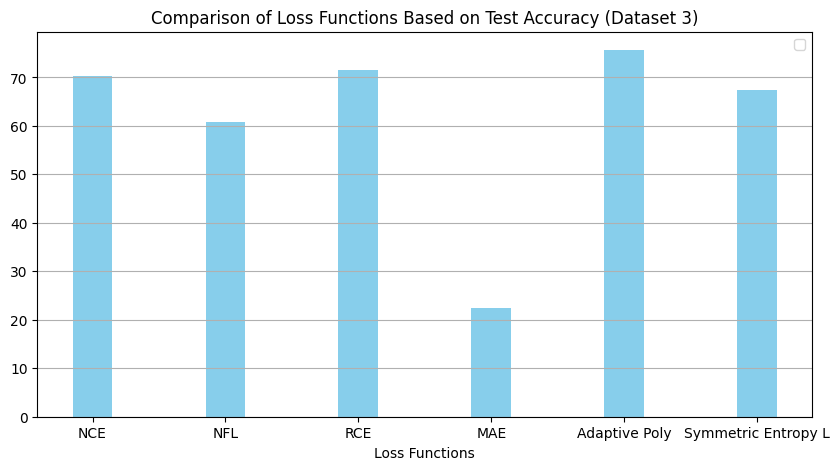

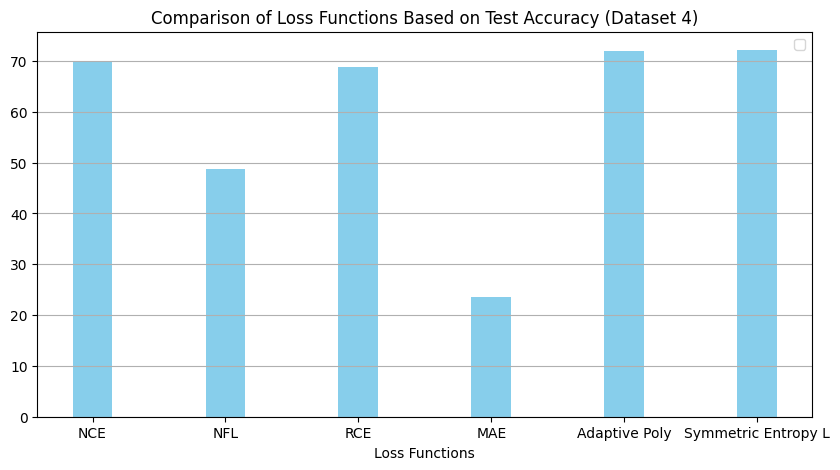

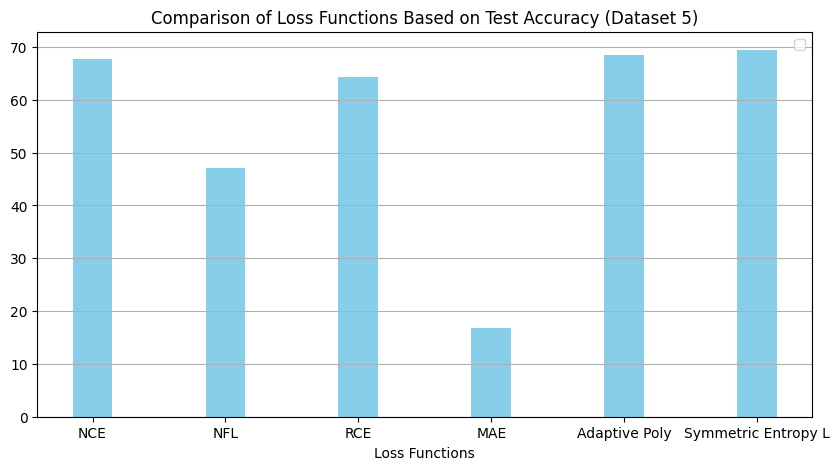

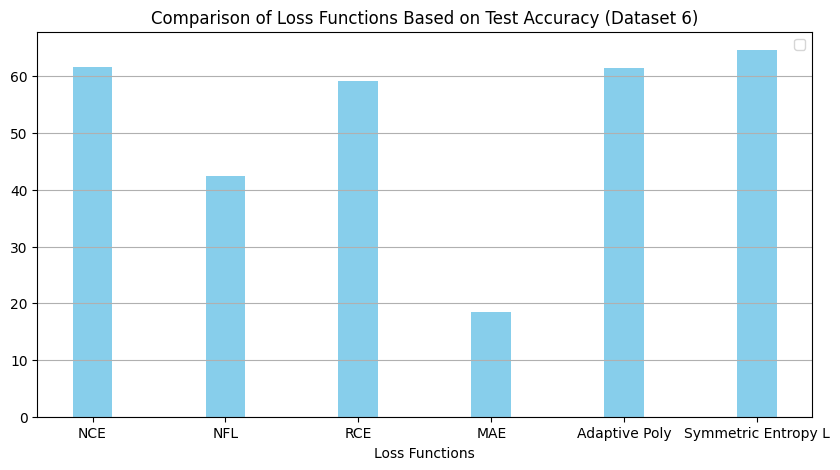

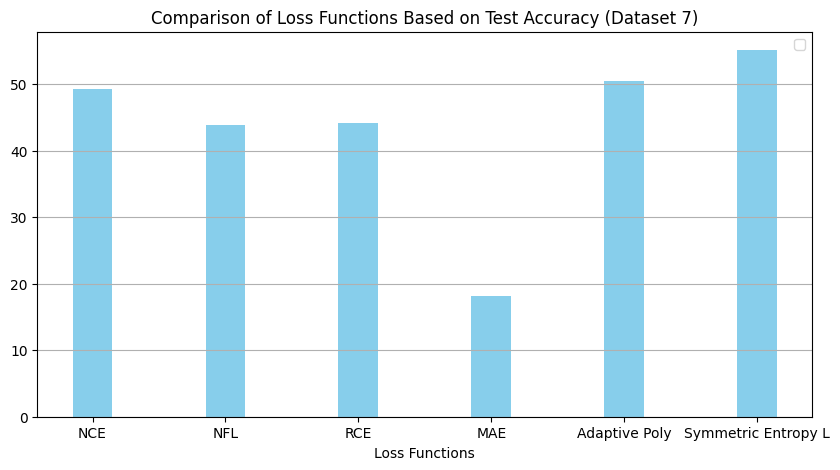

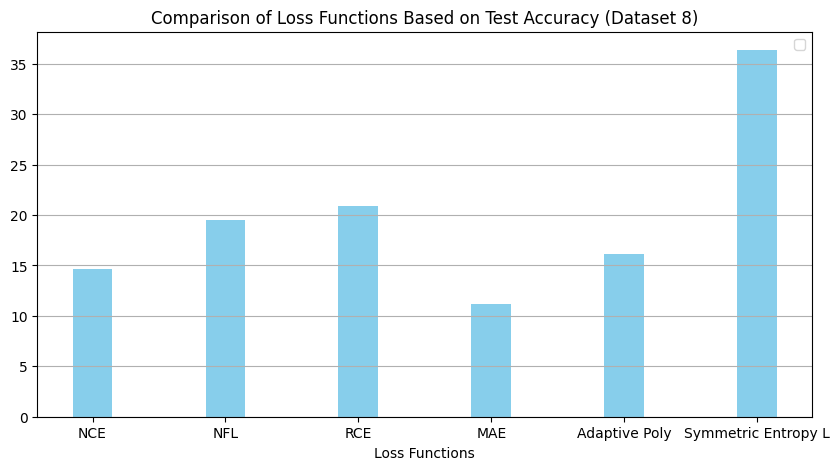

In [3]:
def compare_results(results_loss_functions, results_adaptive_poly, dataset_names):
    manual_test_acc_values = [
        {"NCE": 78.81, "NFL": 78.09, "RCE": 80.18, "MAE": 79.24, "Adaptive Poly": 80.7},  
        {"NCE": 79.13, "NFL": 65.85, "RCE": 75.50, "MAE": 42.20, "Adaptive Poly": 79.21, "Symmetric Entropy L": 74.52},  
        {"NCE": 77.28, "NFL": 67.54, "RCE": 75.44, "MAE": 36.58, "Adaptive Poly": 78.55, "Symmetric Entropy L": 73.81},  
        {"NCE": 70.24, "NFL": 60.84, "RCE": 71.49, "MAE": 22.45, "Adaptive Poly": 75.64, "Symmetric Entropy L": 67.46},  
        {"NCE": 70.09, "NFL": 48.76, "RCE": 68.75, "MAE": 23.59, "Adaptive Poly": 71.96, "Symmetric Entropy L": 72.15},  
        {"NCE": 67.64, "NFL": 47.08, "RCE": 64.24, "MAE": 16.79, "Adaptive Poly": 68.51, "Symmetric Entropy L": 69.42},  
        {"NCE": 61.61, "NFL": 42.44, "RCE": 59.12, "MAE": 18.54, "Adaptive Poly": 61.53, "Symmetric Entropy L": 64.64},  
        {"NCE": 49.31, "NFL": 43.92, "RCE": 44.18, "MAE": 18.17, "Adaptive Poly": 50.49, "Symmetric Entropy L": 55.12},  
        {"NCE": 14.64, "NFL": 19.55, "RCE": 20.90, "MAE": 11.18, "Adaptive Poly": 16.18, "Symmetric Entropy L": 36.37}   
    ]
    
    for i in range(9):  # Loop over datasets
        plt.figure(figsize=(10, 5))
        test_acc = manual_test_acc_values[i]

        plt.bar(test_acc.keys(), test_acc.values(), color='skyblue', width=0.3) 
        
        plt.xlabel("Loss Functions")
        plt.title(f"Comparison of Loss Functions Based on Test Accuracy ({dataset_names[i]})")
        plt.legend()
        plt.grid(axis="y")
        plt.show()


dataset_names = [f"Dataset {i}" for i in range(9)]

compare_results(None, None, dataset_names)


# **Comparison of Loss Functions Across Datasets**

This table presents the **maximum test accuracy** achieved by different loss functions on datasets with varying noise levels.

## **Key Observations**
- **Low-Noise Datasets (Dataset 0 - Dataset 2)**:  
  - **Adaptive Poly Loss (APL)** and **RCE Loss** consistently outperform others, reaching peak accuracy (~80%).  
  - **NCE Loss** follows closely, while **NFL and MAE perform worse**, especially as noise increases.  

- **Moderate-Noise Datasets (Dataset 3 - Dataset 6)**:  
  - Performance degrades, but **APL remains the strongest**, followed by **Symmetric Entropy L** and **NCE**.  
  - **NFL and MAE show significant performance drops**, indicating weaker robustness to noise.  

- **High-Noise Datasets (Dataset 7 - Dataset 8)**:  
  - Performance declines sharply across all loss functions.  
  - **Symmetric Entropy L outperforms all others in extreme noise**, suggesting strong robustness.  
  - **MAE suffers the most, failing to generalize in high-noise conditions.**  

## **Possible Improvements**
- **Adaptive Loss Fusion:** Combining **APL and Symmetric Entropy L** could yield better results in varying noise levels.  
- **Noise-Aware Training:** Applying **curriculum learning or self-ensembling** might improve performance in high-noise datasets.  
- **Regularization Techniques:** Adding **confidence-based filtering or noise correction** could enhance model robustness further.  
